In [1]:
%load_ext autoreload
%autoreload 2

# !python3 -m pip install /home/ubuntu/Anantak/Pipelines/pycolmap-0.4.0

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, pairs_from_retrieval, pairs_from_ios_poses
from hloc import reconstruction, localize_sfm, visualization

from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Pipeline for ANA image data

## Setup
Here we declare the paths to the dataset, the reconstruction and localization outputs, and we choose the feature extractor and the matcher. 

In [2]:
dataset = Path('datasets/testtrack/')
images = Path('datasets/testtrack/frames/')
outputs = Path('outputs/testtrack/')

sfm_pairs = outputs / 'pairs-db-covis20.txt'  # top 20 most covisible in SIFT model
loc_pairs = outputs / 'pairs-query-netvlad20.txt'  # top 20 retrieved by NetVLAD
reference_sfm = outputs / 'sfm_superpoint+superglue'  # the SfM model we will build
sfm_dir = outputs / 'sfm'

# list the standard configurations available
# print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
# print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

In [3]:
# pick one of the configurations for image retrieval, local feature extraction, and matching
# you can also simply write your own here!
retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

## Extract local features for database and query images

In [4]:
features = extract_features.main(feature_conf, images, outputs)

[2023/12/18 22:18:14 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
[2023/12/18 22:18:14 hloc INFO] Found 795 images in root datasets/testtrack/frames.
[2023/12/18 22:18:14 hloc INFO] Skipping the extraction.


The function returns the path of the file in which all the extracted features are stored.

Features were exported to file: outputs/testtrack/feats-disk.h5
outputs/testtrack/feats-disk.h5


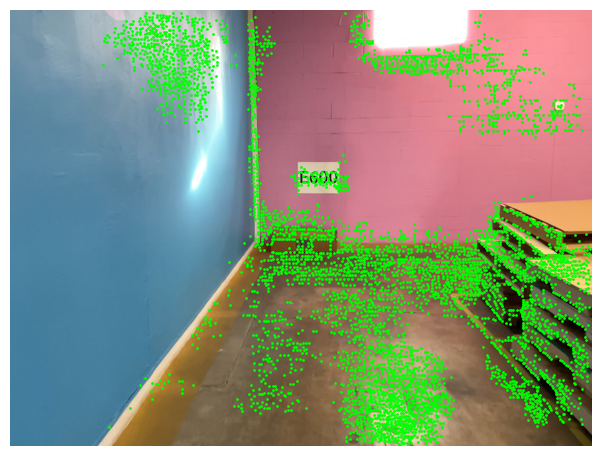

In [5]:
# This is the file where the features were saved
print(f'Features were exported to file: {features}')

# How can we plot the exported features?
from hloc.utils.io import list_h5_names, read_image, get_keypoints
from hloc.utils.viz import plot_images, plot_keypoints

sample_image_names_list = list_h5_names(features)

sample_idx = 3
sample_image_name = sample_image_names_list[sample_idx] #'db/1931.jpg'
sample_image_path = images / sample_image_name
sample_image = read_image(sample_image_path)
sample_image_kps = get_keypoints(features, sample_image_name)

plot_images([sample_image])
plot_keypoints([sample_image_kps])


## Generate pairs for the SfM reconstruction
Instead of matching all database images exhaustively, we exploit the existing SIFT model to find which image pairs are the most covisible. We first convert the SIFT model from the NVM to the COLMAP format, and then do a covisiblity search, selecting the top 20 most covisibile neighbors for each image.

In [7]:
# Define the file paths
poses_file_path = Path.home() / 'Anantak/Pipelines/Hierarchical-Localization/datasets/testtrack/poses.txt'
rotation_threshold = 15

# Call the main function of your script
pairs_from_ios_poses.main(
    poses_file=poses_file_path,
    output=sfm_pairs,
    num_matched=74970,
    rotation_threshold=rotation_threshold
)

Found 74969 pairs written to outputs/testtrack/pairs-db-covis20.txt


## Match the database images

In [ ]:
# Call the main function of match_features
print(f"Type of sfm_pairs: {type(sfm_pairs)}, Value: {sfm_pairs}")
print(f"Type of feature_file_name: {type(feature_conf['output'])}, Value: {feature_conf['output']}")
sfm_matches = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)
print(f'sfm matches were saved in file {sfm_matches}')

The function returns the path of the file in which all the computed matches are stored.

## Triangulate a new SfM model from the given poses
We triangulate the sparse 3D pointcloud given the matches and the reference poses stored in the SIFT COLMAP model.

In [ ]:
sfm_dir = Path('/home/ubuntu/Anantak/Pipelines/Hierarchical-Localization/datasets/testtrack/frames/')
images_path = Path('/home/ubuntu/Anantak/Pipelines/Hierarchical-Localization/datasets/testtrack/frames/')
sfm_pairs_path = Path('/home/ubuntu/Anantak/Pipelines/Hierarchical-Localization/outputs/testtrack/pairs-db-covis20.txt')
features_path = Path('/home/ubuntu/Anantak/Pipelines/Hierarchical-Localization/outputs/testtrack/feats-disk.h5')
matches_path = Path('/home/ubuntu/Anantak/Pipelines/Hierarchical-Localization/outputs/testtrack/feats-disk_matches-disk-lightglue_pairs-db-covis20.h5')

model = reconstruction.main(
    sfm_dir=sfm_dir,
    image_dir=images_path,
    pairs=sfm_pairs_path,
    features=features_path,
    matches=matches_path
    )

In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the $k$ most similar ones. A larger $k$ improves the robustness of the localization for difficult queries but makes the matching more expensive. Using $k{=}10{-}20$ is generally a good tradeoff but $k{=}50$ gives the best results for the Aachen Day-Night dataset.

In [ ]:
global_descriptors = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(global_descriptors, loc_pairs, num_matched=20, db_prefix="", query_prefix="")

## Match the query images

In [ ]:
loc_matches = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [ ]:
# results = outputs / 'Aachen_hloc_superpoint+superglue_netvlad20.txt'  # the result file
# localize_sfm.main(
#     reconstruction,
#     dataset / 'queries/*_time_queries_with_intrinsics.txt',
#     loc_pairs,
#     features,
#     loc_matches,
#     results,
#     covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

reference_sfm = Path('datasets/testtrack/frames')
queries = Path('datasets/testtrack/frames/query_with_intrinsics.txt')
features = Path('outputs/testtrack/feats-disk.h5')
matches = Path('outputs/testtrack/feats-disk_matches-disk-lightglue_pairs-query-netvlad20.h5')
retrieval = Path('outputs/testtrack/pairs-query-netvlad20.txt')
results = Path('outputs/testtrack/estimated_poses.txt')

localize_sfm.main(
    reference_sfm=reference_sfm,
    queries=queries,
    retrieval=retrieval,
    features=features,
    matches=matches,
    results=results,
    ransac_thresh=12.0,
    covisibility_clustering=False,
    prepend_camera_name=False
)

## Visualizing the SfM model
We visualize some of the database images with their detected keypoints.
Color the keypoints by track length: red keypoints are observed many times, blue keypoints few.

In [ ]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by='track_length')

Color the keypoints by visibility: blue if sucessfully triangulated, red if never matched.

In [ ]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by='visibility')

Color the keypoints by triangulated depth: red keypoints are far away, blue keypoints are closer.

In [ ]:
visualization.visualize_sfm_2d(reconstruction, images, n=1, color_by='depth')

## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

In [ ]:
visualization.visualize_loc(
    results, images, reconstruction, n=1, top_k_db=1, prefix='', seed=2)